# Analyse DPA de l’AES

Ce notebook documente la mise en œuvre d’une attaque *Differential Power Analysis (DPA)* sur AES à partir de traces publiques.

**Objectif.** Retrouver (ou vérifier) des octets de la clé AES en ciblant la sortie de **SubBytes** au 1er tour.

**Plan rapide :**
1) Imports & réglages de reproductibilité  
2) Chargement du jeu de traces (.ets)  
3) Vérifications / informations de base

> Attribution : les traces proviennent d’un dépôt public (référencé plus tard dans le README du projet).


#### Imports

In [1]:
# Dépendances + réplicabilité
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

# Réglages d'affichage
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["axes.grid"] = True

# Graine pour rendre les tirages pseudo-aléatoires reproductibles
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)


## Chargement du jeu de traces

On utilise un fichier **ETS** (format SideSCA) contenant les mesures et les métadonnées
(plaintext, key, ciphertext, etc.). On garde le chemin dans une constante pour être clair.

In [2]:
# Chemin vers le fichier ETS
ETS_PATH = "SideSCA-Traces-Public/AES_traces_set_1st_round.ets"

import estraces

# Lecture du set de traces
ths = estraces.read_ths_from_ets_file(ETS_PATH)


### Informations de base

On affiche les métadonnées fournies par le lecteur ETS et la taille du set (nombre de traces).


In [3]:
# Affiche le résumé du set (format ETS + champs disponibles)
print(ths)

# Nombre de traces
print(f"Nombre de traces : {len(ths)}")


Trace Header Set:
Name.............: ETS Format THS
Reader...........: ETS format reader of file SideSCA-Traces-Public/AES_traces_set_1st_round.ets with 2000 traces.
ciphertext.......: uint8
key..............: uint8
plaintext........: uint8

Nombre de traces : 2000


In [4]:
#Inspection de l'objet 'ths' pour trouver traces et métadonnées
def inspect_ths(obj):
    print("Type :", type(obj))
    # Attributs publics
    attrs = [a for a in dir(obj) if not a.startswith("_")]
    print("\nExemples d'attributs/méthodes disponibles (quelques-uns) :")
    for a in attrs[:60]:
        print("  ", a)
    # Essayons d'extraire automatiquement quelques choses utiles
    candidates = {}
    for name in ("traces", "get_traces", "get_traces_array", "read_traces", "raw_traces"):
        if hasattr(obj, name):
            candidates["traces_attr"] = name
            break
    for name in ("plaintext", "plaintexts", "get_plaintexts", "pt", "pts"):
        if hasattr(obj, name):
            candidates["plaintexts_attr"] = name
            break
    for name in ("key", "keys", "get_keys", "key_array"):
        if hasattr(obj, name):
            candidates["keys_attr"] = name
            break
    print("\nTentative d'attributs utiles trouvés :", candidates)

inspect_ths(ths)


Type : <class 'estraces.traces._metaclass.TraceHeaderSetForETSFormatReader'>

Exemples d'attributs/méthodes disponibles (quelques-uns) :
   ciphertext
   close
   filename
   filter
   get
   get_attr
   get_points
   get_trace_by_index
   h5_file
   headers
   key
   metadata_tags
   metadatas
   name
   plaintext
   samples
   split
   traces

Tentative d'attributs utiles trouvés : {'traces_attr': 'traces', 'plaintexts_attr': 'plaintext', 'keys_attr': 'key'}


In [5]:
# Extraction des tableaux et affichage d'exemples
import numpy as np

# 1) Récupération
traces = np.asarray(ths.traces)           
plaintexts = np.asarray(ths.plaintext)    
keys = np.asarray(ths.key) if hasattr(ths, "key") else None
ciphertexts = np.asarray(ths.ciphertext) if hasattr(ths, "ciphertext") else None

# 2) Forme / infos basiques
print("=== Formes et infos ===")
print("traces.shape :", getattr(traces, "shape", None))
print("plaintexts.shape :", getattr(plaintexts, "shape", None))
print("keys.shape :", None if keys is None else keys.shape)
print("ciphertexts.shape :", None if ciphertexts is None else ciphertexts.shape)
print("ths.samples (points par trace) :", getattr(ths, "samples", None))
print("nombre de traces selon len(ths) :", len(ths))

# 3) Affichage d'exemples 
def pretty_print_plaintext(pt):
    # si c'est un tableau 1D d'octets ou une série d'octets/bytes -> afficher hex
    try:
        arr = np.asarray(pt, dtype=np.uint8)
        if arr.ndim == 1 and arr.size >= 1 and arr.size <= 32:
            return " ".join(f"{b:02x}" for b in arr.tolist())
    except Exception:
        pass
    # si c'est bytes
    if isinstance(pt, (bytes, bytearray)):
        return pt.hex()
    return str(pt)

print("\n=== Exemples ===")
n_show = min(5, traces.shape[0])
print(f"Montrer {n_show} premiers plaintexts (hex / octets) :")
for i in range(n_show):
    print(f" [{i}] ->", pretty_print_plaintext(plaintexts[i]))


print("\nPremier élément de key :", keys[0] if keys is not None else "absent")

# extraction d'une trace (les points de mesure)
trace0 = None
if hasattr(traces[0], "samples"):
    trace0 = traces[0].samples
else:
    trace0 = np.asarray(traces[0])

print("Nombre de points dans la première trace :", len(trace0))
print("Extrait (10 premiers points) :", trace0[:10])
print("Statistiques première trace -> min, max, mean :",
      float(np.min(trace0)), float(np.max(trace0)), float(np.mean(trace0)))



=== Formes et infos ===
traces.shape : (2000,)
plaintexts.shape : (2000, 16)
keys.shape : (2000, 16)
ciphertexts.shape : (2000, 16)
ths.samples (points par trace) : array([[-20,   8,  30, ...,  14, -40, -29],
       [-20,   8,  30, ...,  11, -40, -29],
       [-20,   8,  30, ...,  14, -40, -29],
       ...,
       [-20,   8,  30, ...,  14, -40, -29],
       [-20,   8,  30, ...,  15, -40, -29],
       [-20,   8,  30, ...,  15, -40, -29]], dtype=int8)
nombre de traces selon len(ths) : 2000

=== Exemples ===
Montrer 5 premiers plaintexts (hex / octets) :
 [0] -> 16 ab f3 ab 59 11 0d 78 8e 3b 80 0d e2 85 84 cb
 [1] -> 4f c1 48 fe 95 ad 7e 2d d8 86 34 0e fb c6 ef 28
 [2] -> 56 88 30 43 38 b9 50 b1 b6 4c 89 9f 4d 1c 63 bb
 [3] -> 0f 21 0b d5 e9 eb d6 ef 16 82 3d b1 e4 7c ba a5
 [4] -> df 24 34 f5 31 cc b6 b1 f7 9f ff 65 ce 5b 90 95

Premier élément de key : [143   3 231 122 236 102  88  10  19  43 210  59 245  99  78  15]
Nombre de points dans la première trace : 3000
Extrait (10 premiers po

In [6]:
traces_np_array = ths.samples
print(type(traces_np_array))
print(traces_np_array)
traces_np_array.shape

<class 'estraces.traces.samples.Samples'>
array([[-20,   8,  30, ...,  14, -40, -29],
       [-20,   8,  30, ...,  11, -40, -29],
       [-20,   8,  30, ...,  14, -40, -29],
       ...,
       [-20,   8,  30, ...,  14, -40, -29],
       [-20,   8,  30, ...,  15, -40, -29],
       [-20,   8,  30, ...,  15, -40, -29]], dtype=int8)


(2000, 3000)

## Visualisation des traces

Avant de lancer l’attaque, on observe les signaux mesurés.
Chaque trace correspond à une exécution d’AES.  
On peut afficher la première trace, puis plusieurs superposées pour voir la variabilité.


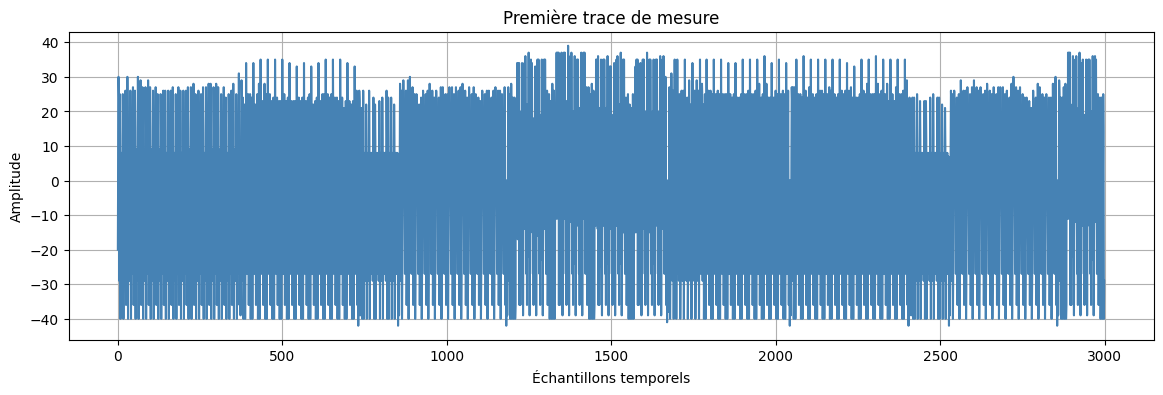

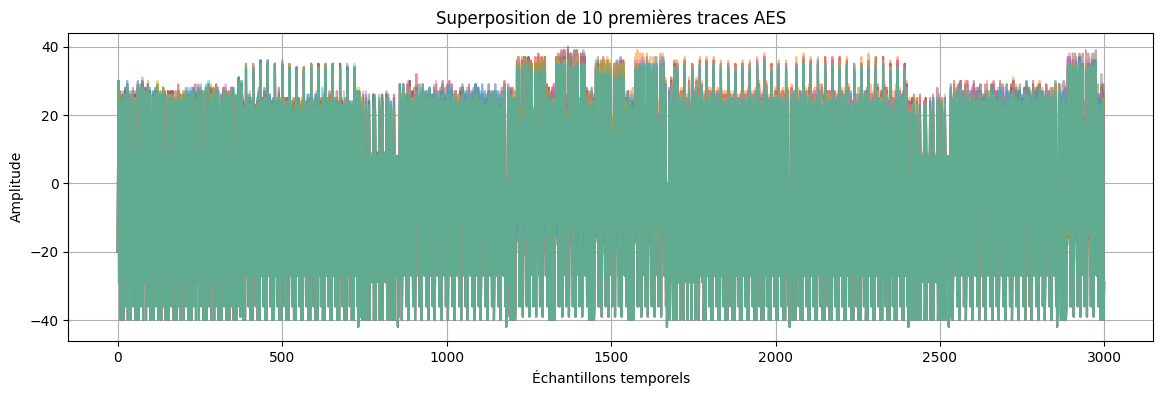

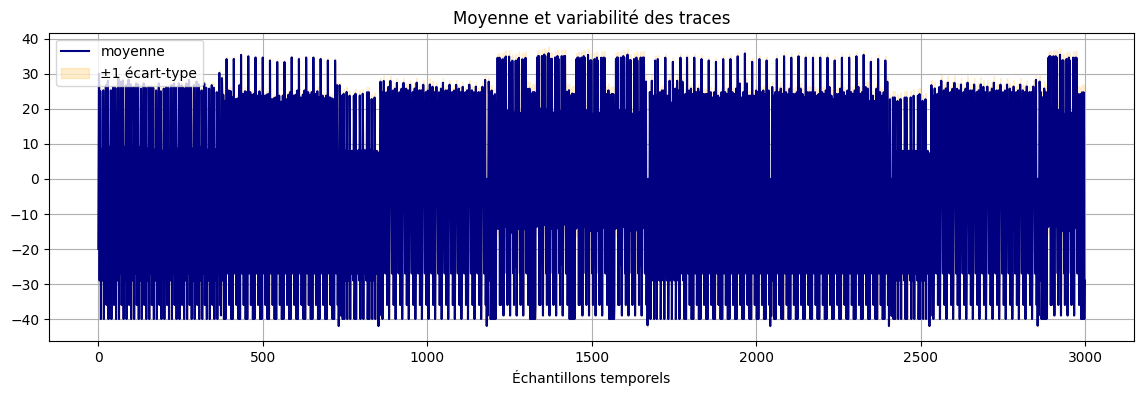

In [7]:
# --- Visualisation des traces AES ---

# Afficher une seule trace 
plt.figure(figsize=(14, 4))
plt.plot(ths[0].samples.T, color='steelblue')
plt.title("Première trace de mesure")
plt.xlabel("Échantillons temporels")
plt.ylabel("Amplitude")
plt.show()

# Afficher plusieurs traces pour voir la variabilité
plt.figure(figsize=(14, 4))
for i in range(10):  # 10 premières
    plt.plot(ths[i].samples.T, alpha=0.5)
plt.title("Superposition de 10 premières traces AES")
plt.xlabel("Échantillons temporels")
plt.ylabel("Amplitude")
plt.show()

# Calcul de la moyenne et écart-type pour un aperçu global
import numpy as np
all_traces = np.array([t.samples for t in ths])
mean_trace = np.mean(all_traces, axis=0)
std_trace = np.std(all_traces, axis=0)

plt.figure(figsize=(14, 4))
plt.plot(mean_trace, label="moyenne", color='navy')
plt.fill_between(range(len(mean_trace)),
                 mean_trace - std_trace,
                 mean_trace + std_trace,
                 alpha=0.2, color='orange', label="±1 écart-type")
plt.title("Moyenne et variabilité des traces")
plt.xlabel("Échantillons temporels")
plt.legend()
plt.show()


## Ciblage des calculs intermédiaires dans l’AES

Pour réaliser une attaque **DPA (Differential Power Analysis)**, on ne cherche pas à deviner toute la clé AES d’un coup,  
mais plutôt **un seul octet à la fois** — c’est le principe du *divide-and-conquer*.

En connaissant les **plaintexts** (ou ciphertexts), on peut reproduire les **valeurs intermédiaires** manipulées par le circuit,
par exemple la sortie de l’opération **SubBytes** du premier tour.

L’idée est la suivante :

- Pour chaque hypothèse possible d’un octet de clé (0 à 255),
  on calcule les valeurs intermédiaires correspondantes (ici, `SubBytes(plaintext_byte ⊕ key_guess)`).
- Ces valeurs servent à **séparer les traces de consommation** en deux groupes selon un modèle de fuite
  (par exemple, si un bit particulier vaut 0 ou 1).
- Si l’hypothèse est correcte, la différence de moyenne entre les deux groupes fera apparaître un **pic significatif**.

Autrement dit, seule la bonne hypothèse de clé reproduira réellement les valeurs manipulées par le dispositif,  
et c’est celle-là qui générera le pic DPA le plus net.

---

### Schéma de principe (premiers tours de l’AES)
*(issu du cours, rappel du flot de données manipulées)*


<img src="./images/AESscheme.png" width="300px">

## Fonction de sélection : sortie de SubBytes (1er tour)

On définit la fonction `aes_first_round_sbox_out` qui calcule, pour chaque trace, la valeur
intermédiaire ciblée `SubBytes(plaintext_byte ⊕ key_guess)` pour un octet donné.  
On ajoute aussi un petit wrapper `selection_subbytes` qui renvoie soit la valeur entière (0..255),
soit un bit choisi de la sortie (0 = LSB), selon le modèle de fuite utilisé.


In [8]:
import scared

def aes_function_firstRde_SBout(plaintext, key):
    return scared.aes.encrypt(
        plaintext=plaintext,
        key=key,
        at_round=1,
        after_step=scared.aes.base.Steps.SUB_BYTES
    )

# Exécution de la DPA automatique avec scared
container = scared.Container(ths)

Selection_function = scared.reverse_selection_function(aes_function_firstRde_SBout)

Reverse_SB = scared.DPAReverse(
    selection_function=Selection_function,
    model=scared.Monobit(0)  # bit 0, modèle monobit
)

Reverse_SB.run(container)

print("Shape des résultats :", Reverse_SB.results.shape)


Shape des résultats : (16, 3000)


## Lancement de l’attaque DPA complète avec `scared`

Nous allons maintenant utiliser la fonction de sélection `aes_function_firstRde_SBout`
dans une attaque DPA automatisée via `scared`.

L’objectif : retrouver les 16 octets de la clé AES à partir des traces mesurées.

Le modèle de fuite choisi est **Monobit(0)**, c’est-à-dire que l’on observe le **bit de poids faible**
de la sortie de SubBytes.  
Le discriminateur choisi (`scared.maxabs`) permet de retenir la valeur absolue maximale du pic DPA
comme score pour chaque hypothèse.


In [9]:
import numpy as np

# --- Création du tableau de traces ---
traces_array = np.array([np.asarray(t.samples) for t in ths])
plaintexts = np.asarray([t.plaintext for t in ths])
keys = np.asarray([t.key for t in ths])

print("traces_array.shape =", traces_array.shape)
print("plaintexts.shape =", plaintexts.shape)
print("keys.shape =", keys.shape)
print("Nombre de traces :", len(ths))
print("Nombre de points par trace :", traces_array.shape[1])


traces_array.shape = (2000, 3000)
plaintexts.shape = (2000, 16)
keys.shape = (2000, 16)
Nombre de traces : 2000
Nombre de points par trace : 3000


In [10]:
# S-box et fonctions
SBOX = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

def subbyte_vals_for_guess(plaintexts, byte_idx, guess):
    p = np.asarray(plaintexts)
    if p.ndim == 2:
        t = p[:, byte_idx].astype(np.uint8)
    else:
        t = p.astype(np.uint8)
    return SBOX[(t ^ np.uint8(guess))]

def compute_score_for_guess(traces, plaintexts, byte_idx, guess, leakage_bit=0):
    vals = subbyte_vals_for_guess(plaintexts, byte_idx, guess)
    if leakage_bit is None:
        sel = (vals & 1).astype(bool)
    else:
        sel = ((vals >> leakage_bit) & 1).astype(bool)
    g1 = traces[sel]
    g0 = traces[~sel]
    if g0.shape[0] == 0 or g1.shape[0] == 0:
        return 0.0
    diff = g1.mean(0) - g0.mean(0)
    return float(np.max(np.abs(diff)))

# balayage bits 0..7 et compter octets corrects (manuel)
true_key = np.asarray(ths[0].key).astype(int)
N = traces_array.shape[0]
print("nb traces utilisées :", N)
for bit in range(8):
    scores = np.zeros((256,16), dtype=float)
    for byte_idx in range(16):
        for guess in range(256):
            scores[guess, byte_idx] = compute_score_for_guess(traces_array, plaintexts, byte_idx, guess, leakage_bit=bit)
    found = np.argmax(scores, axis=0)
    n_ok = np.sum(found == true_key)
    print(f"bit {bit} -> {n_ok}/16 octets corrects")


nb traces utilisées : 2000
bit 0 -> 16/16 octets corrects
bit 1 -> 16/16 octets corrects
bit 2 -> 14/16 octets corrects
bit 3 -> 15/16 octets corrects
bit 4 -> 16/16 octets corrects
bit 5 -> 16/16 octets corrects
bit 6 -> 16/16 octets corrects
bit 7 -> 16/16 octets corrects



### Print and plot the result

In [14]:
import numpy as np

bit = 0  # tu peux mettre 0,1,4,5,6,7 d'après ton test

# matrice de scores (256,16) avec ta DoM manuelle
scores_manual = np.zeros((256, 16), dtype=float)
for byte_idx in range(16):
    for guess in range(256):
        scores_manual[guess, byte_idx] = compute_score_for_guess(
            traces_array, plaintexts, byte_idx, guess, leakage_bit=bit
        )

# clé estimée = argmax colonne par colonne
found_key = np.argmax(scores_manual, axis=0).astype(int)
true_key = np.asarray(ths[0].key).astype(int)

vhex = np.vectorize(lambda x: format(int(x), '#04x'))
print("Clé trouvée:", vhex(found_key))
print("Clé correcte        :", vhex(true_key))
print("Octets corrects       :", int(np.sum(found_key == true_key)), "/ 16")


Clé trouvée: ['0x8f' '0x03' '0xe7' '0x7a' '0xec' '0x66' '0x58' '0x0a' '0x13' '0x2b'
 '0xd2' '0x3b' '0xf5' '0x63' '0x4e' '0x0f']
Clé correcte        : ['0x8f' '0x03' '0xe7' '0x7a' '0xec' '0x66' '0x58' '0x0a' '0x13' '0x2b'
 '0xd2' '0x3b' '0xf5' '0x63' '0x4e' '0x0f']
Octets corrects       : 16 / 16


results_time.shape = (16, 3000)


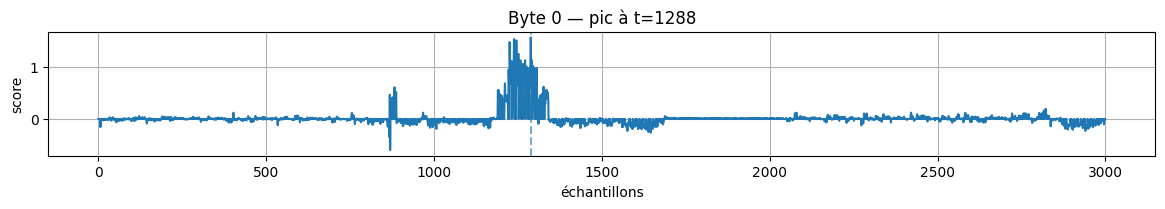

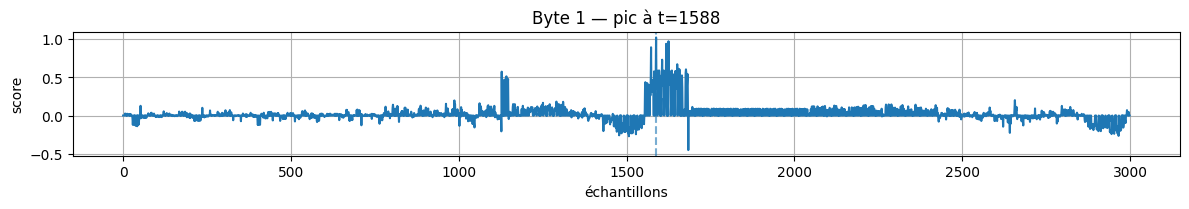

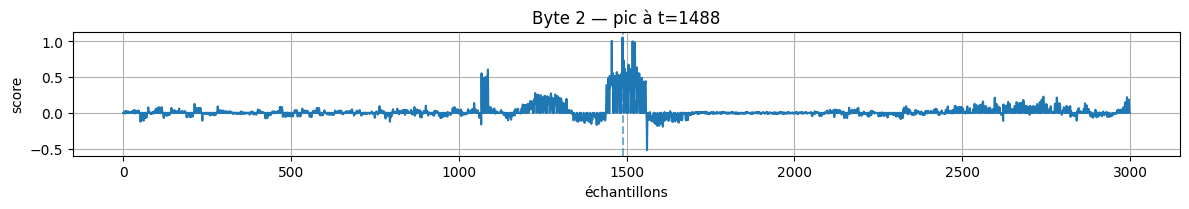

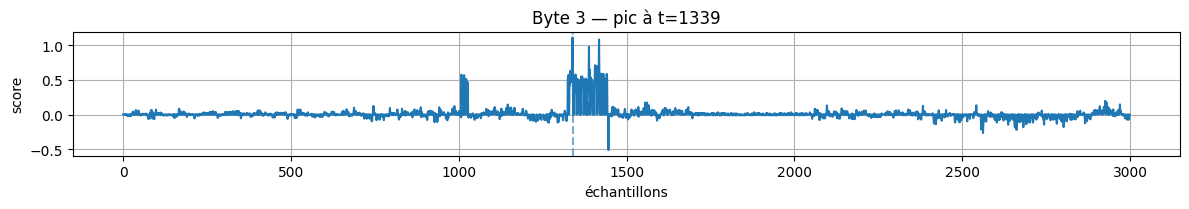

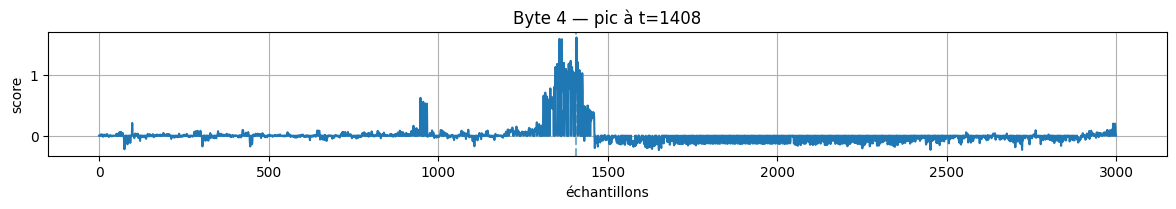

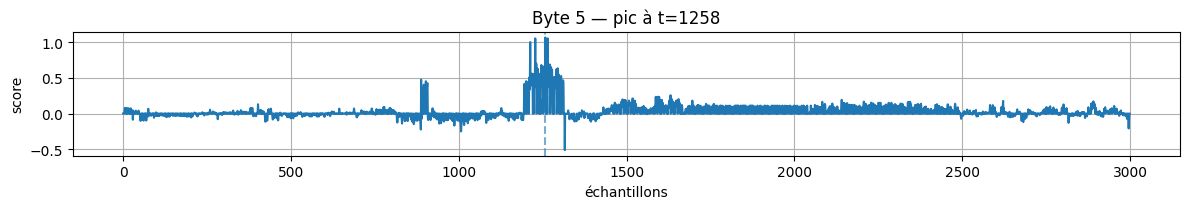

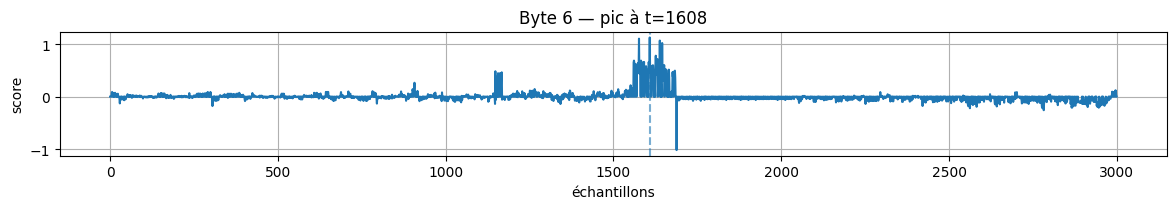

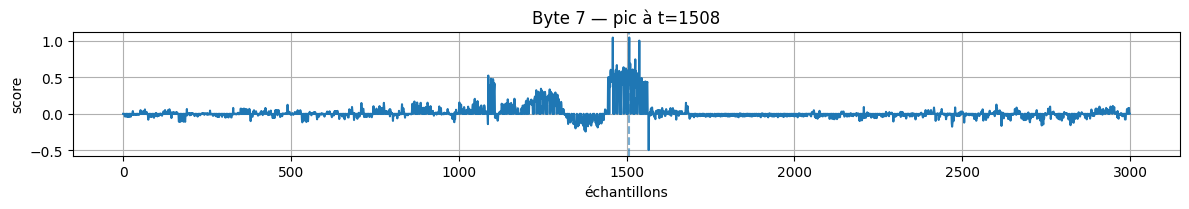

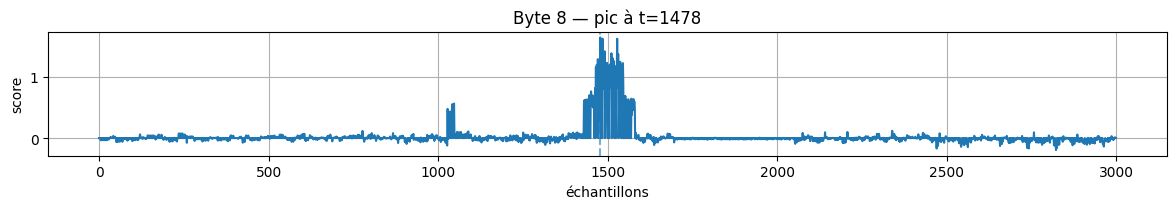

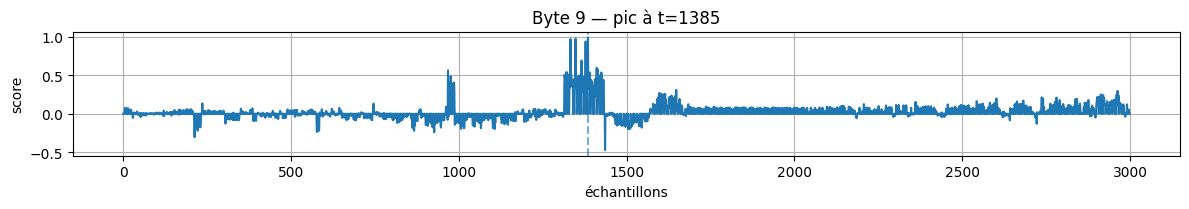

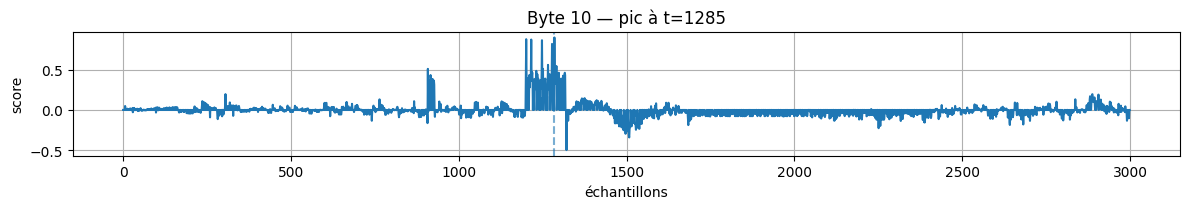

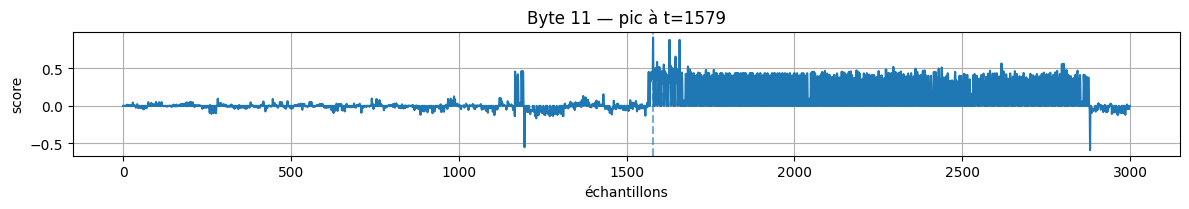

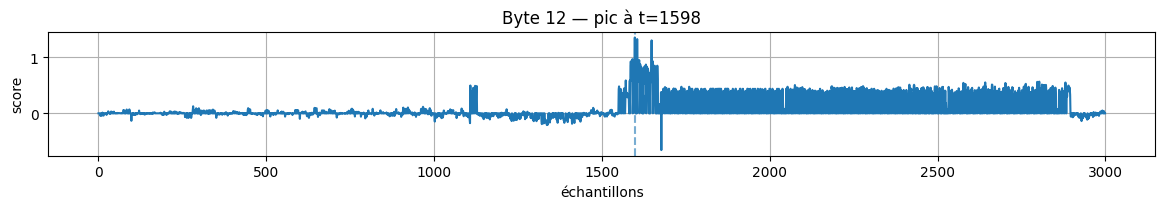

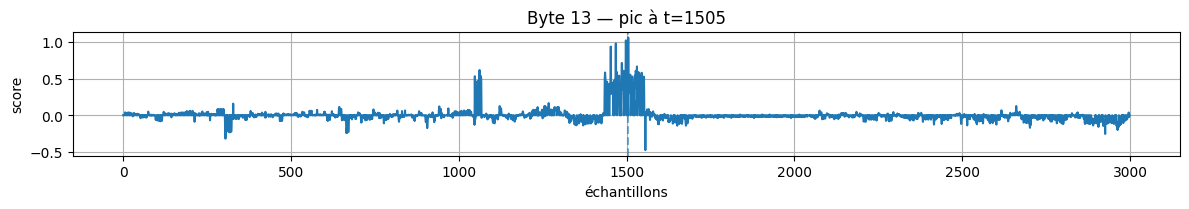

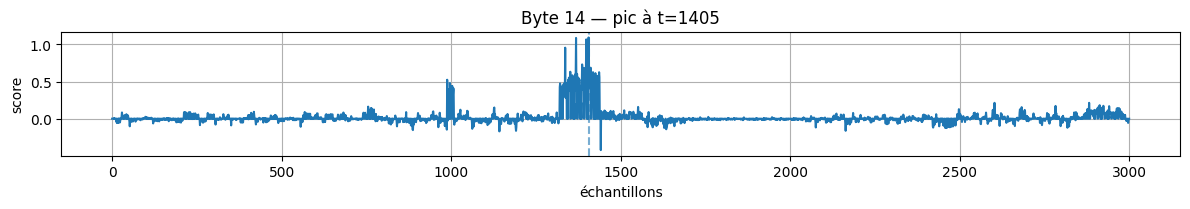

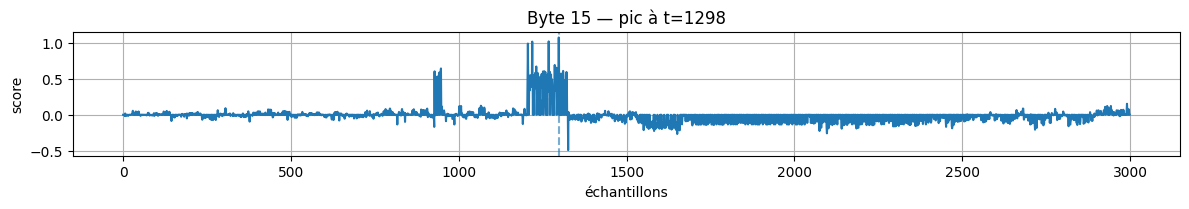

In [16]:
# profils temporels (16, T) donnés par scared
results_time = np.asarray(Reverse_SB.results)  # 16 x temps
print("results_time.shape =", results_time.shape)

# on trace 16 profils (un par octet) avec repère du pic
for i in range(16):
    prof = results_time[i]
    t_peak = int(np.argmax(np.abs(prof)))
    plt.figure(figsize=(12, 2.2))
    plt.plot(prof)
    plt.axvline(t_peak, ls='--', alpha=0.6)
    plt.title(f"Byte {i} — pic à t={t_peak}")
    plt.xlabel("échantillons")
    plt.ylabel("score")
    plt.tight_layout()
    plt.show()


## Visualisation des profils DPA et choix d'une fenêtre d'intérêt (ROI)

Nous superposons les profils DPA (un profil par octet de clé) pour repérer visuellement
les instants temporels où l'on observe les plus forts effets de fuite.

- Le profil de l'octet dont l'hypothèse correcte génère le plus grand pic peut être mis en évidence
  (couleur différente) pour faciliter l'interprétation.
- Sur nos traces, la zone temporelle la plus informative se situe autour de l'intervalle **[1100:1700]**.
  Attaquer uniquement cette fenêtre réduit le bruit non pertinent et accélère l'analyse,
  tout en améliorant souvent la qualité des scores DPA.

**Méthodologie recommandée :**
1. Tracer les profils DPA pour les 16 octets.  
2. Repérer la zone (ROI) où la majorité des pics se concentrent.  
3. Relancer l'attaque (DoM / DPA) en ne considérant que `traces[:, ROI]`.  
4. Comparer les résultats et retenir le paramétrage le plus performant.


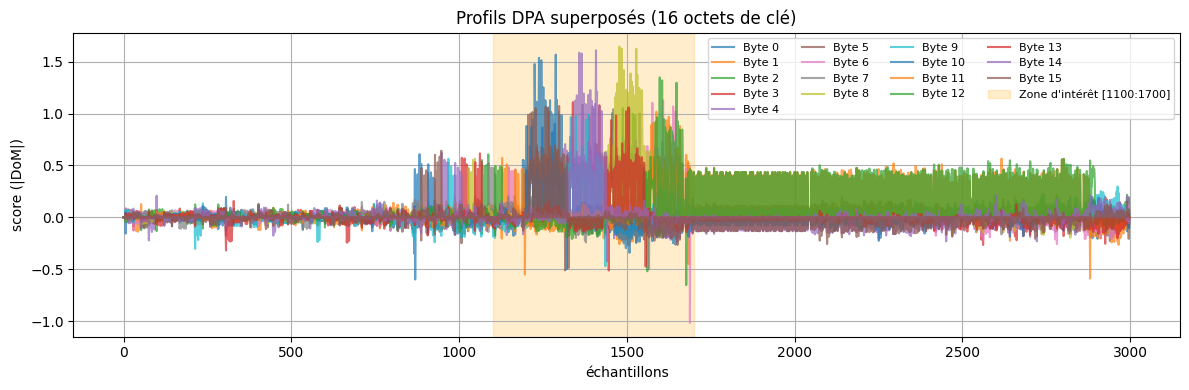

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# --- Superposition des 16 profils DPA ---
plt.figure(figsize=(12,4))
for i in range(16):
    plt.plot(results_time[i], alpha=0.7, label=f'Byte {i}')

# zone d'intérêt (ROI)
plt.axvspan(1100, 1700, color='orange', alpha=0.2, label='Zone d\'intérêt [1100:1700]')

plt.title("Profils DPA superposés (16 octets de clé)")
plt.xlabel("échantillons")
plt.ylabel("score (|DoM|)")
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()


In [25]:
# Définir la fenêtre d'intérêt
ROI = slice(1100, 1700)
traces_roi = traces_array[:, ROI]

# recalcul des scores uniquement sur cette zone
bit = 0
scores_roi = np.zeros((256, 16), dtype=float)
for byte_idx in range(16):
    for guess in range(256):
        scores_roi[guess, byte_idx] = compute_score_for_guess(
            traces_roi, plaintexts, byte_idx, guess, leakage_bit=bit
        )

found_roi = np.argmax(scores_roi, axis=0)
true_key = np.asarray(ths[0].key).astype(int)

print("Résultats avec fenêtre [1100:1700]")
print("Octets corrects :", int(np.sum(found_roi == true_key)), "/ 16")


Résultats avec fenêtre [1100:1700]
Octets corrects : 16 / 16


In [26]:
print("Score global sans ROI :", np.sum(found_key == true_key))
print("Score global avec ROI :", np.sum(found_roi == true_key))


Score global sans ROI : 16
Score global avec ROI : 16


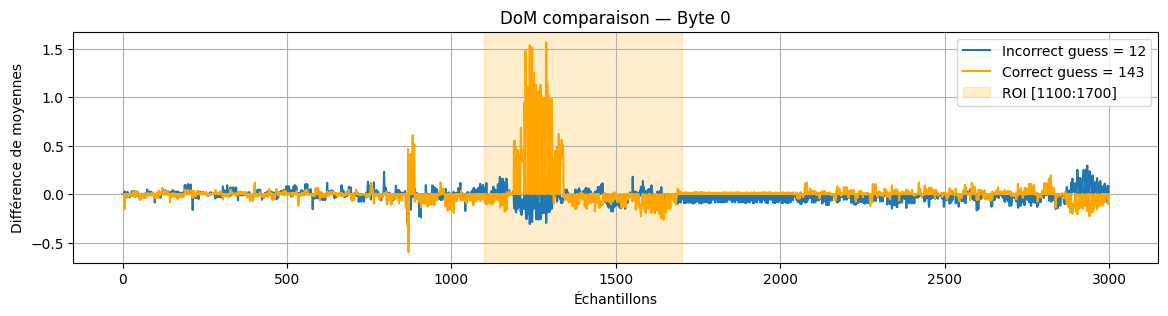

In [27]:
import matplotlib.pyplot as plt

# --- paramètres pour l'exemple ---
byte_idx = 0
bit = 0
incorrect_guess = 12  # hypothèse volontairement fausse
true_key = np.asarray(ths[0].key).astype(int)
correct_guess = int(true_key[byte_idx])

# --- fonction DoM pour une hypothèse ---
def compute_DoM_for_guess(traces, plaintexts, byte_idx, guess, leakage_bit=0):
    vals = subbyte_vals_for_guess(plaintexts, byte_idx, guess)
    sel = ((vals >> leakage_bit) & 1).astype(bool)
    g1 = traces[sel]
    g0 = traces[~sel]
    if g1.shape[0] == 0 or g0.shape[0] == 0:
        return np.zeros(traces.shape[1])
    diff = g1.mean(0) - g0.mean(0)
    return diff

# --- calcul DoM pour une fausse et une vraie hypothèse ---
DoM_incorrect = compute_DoM_for_guess(traces_array, plaintexts, byte_idx, incorrect_guess, bit)
DoM_correct   = compute_DoM_for_guess(traces_array, plaintexts, byte_idx, correct_guess, bit)

# --- affichage ---
plt.figure(figsize=(14,3))
plt.plot(DoM_incorrect, label=f"Incorrect guess = {incorrect_guess}")
plt.plot(DoM_correct, color='orange', label=f"Correct guess = {correct_guess}")
plt.axvspan(1100, 1700, color='orange', alpha=0.2, label='ROI [1100:1700]')
plt.title(f"DoM comparaison — Byte {byte_idx}")
plt.xlabel("Échantillons")
plt.ylabel("Différence de moyennes")
plt.legend()
plt.show()


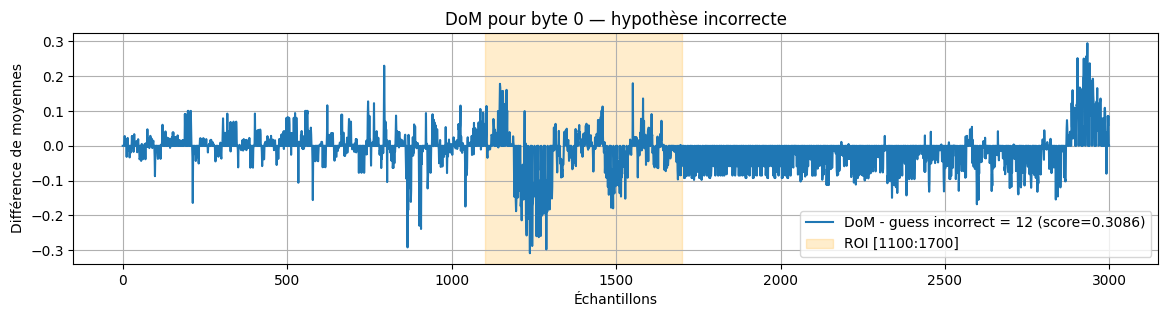

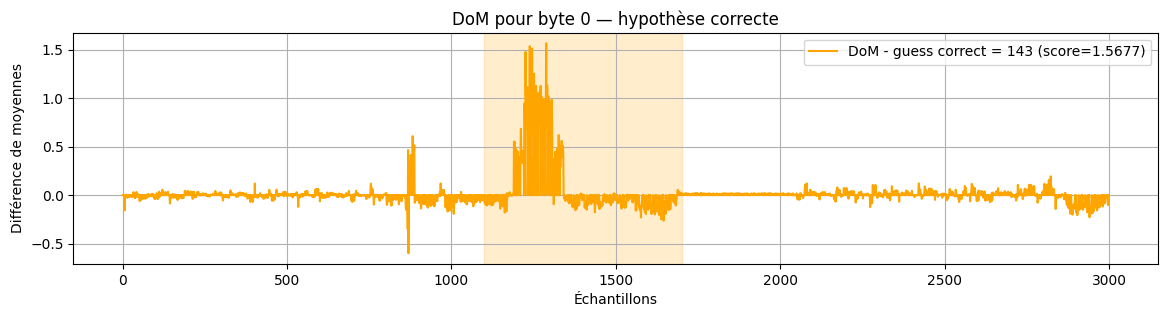

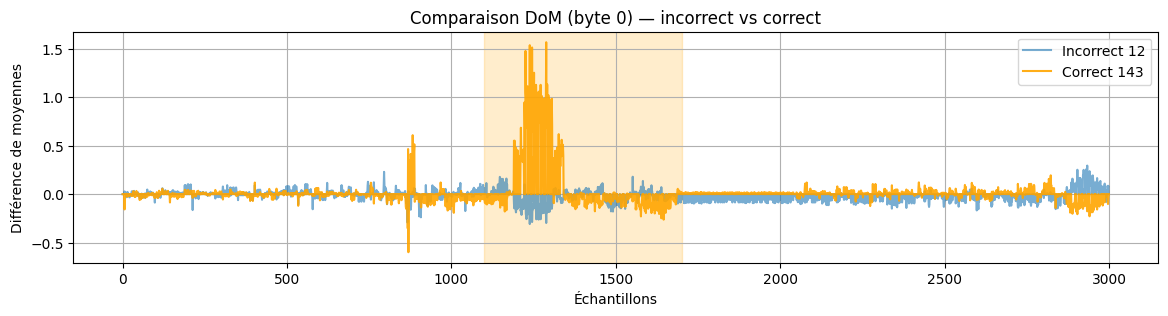

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# --- paramètres ---
byte_idx = 0       # octet attaqué
bit = 0            # bit de fuite utilisé (souvent le LSB)
incorrect_guess = 12  # hypothèse volontairement fausse
true_key = np.asarray(ths[0].key).astype(int)
correct_guess = int(true_key[byte_idx])

# --- fonction DoM pour une hypothèse ---
def compute_DoM_for_guess(traces, plaintexts, byte_idx, guess, leakage_bit=0):
    vals = subbyte_vals_for_guess(plaintexts, byte_idx, guess)
    sel = ((vals >> leakage_bit) & 1).astype(bool)
    g1 = traces[sel]
    g0 = traces[~sel]
    if g1.shape[0] == 0 or g0.shape[0] == 0:
        return np.zeros(traces.shape[1]), 0.0
    diff = g1.mean(0) - g0.mean(0)
    score = float(np.max(np.abs(diff)))
    return diff, score

# --- calcul DoM ---
DoM_incorrect, score_inc = compute_DoM_for_guess(traces_array, plaintexts, byte_idx, incorrect_guess, bit)
DoM_correct, score_cor   = compute_DoM_for_guess(traces_array, plaintexts, byte_idx, correct_guess, bit)

# --- affichage : hypothèse incorrecte ---
plt.figure(figsize=(14,3))
plt.plot(DoM_incorrect, label=f"DoM - guess incorrect = {incorrect_guess} (score={score_inc:.4f})")
plt.axvspan(1100, 1700, color='orange', alpha=0.2, label='ROI [1100:1700]')
plt.title(f"DoM pour byte {byte_idx} — hypothèse incorrecte")
plt.xlabel("Échantillons")
plt.ylabel("Différence de moyennes")
plt.legend()
plt.show()

# --- affichage : hypothèse correcte ---
plt.figure(figsize=(14,3))
plt.plot(DoM_correct, color='orange', label=f"DoM - guess correct = {correct_guess} (score={score_cor:.4f})")
plt.axvspan(1100, 1700, color='orange', alpha=0.2)
plt.title(f"DoM pour byte {byte_idx} — hypothèse correcte")
plt.xlabel("Échantillons")
plt.ylabel("Différence de moyennes")
plt.legend()
plt.show()

# --- comparaison directe ---
plt.figure(figsize=(14,3))
plt.plot(DoM_incorrect, alpha=0.6, label=f"Incorrect {incorrect_guess}")
plt.plot(DoM_correct, color='orange', alpha=0.9, label=f"Correct {correct_guess}")
plt.axvspan(1100, 1700, color='orange', alpha=0.2)
plt.title(f"Comparaison DoM (byte {byte_idx}) — incorrect vs correct")
plt.xlabel("Échantillons")
plt.ylabel("Différence de moyennes")
plt.legend()
plt.show()


dpa_traces.shape = (256, 3000)  scores.shape = (256,)
Byte 0 — top 6 guesses (guess, score):
  143  score=1.567671
   50  score=0.827853
  228  score=0.791961
  122  score=0.773853
  177  score=0.751766
   22  score=0.742944


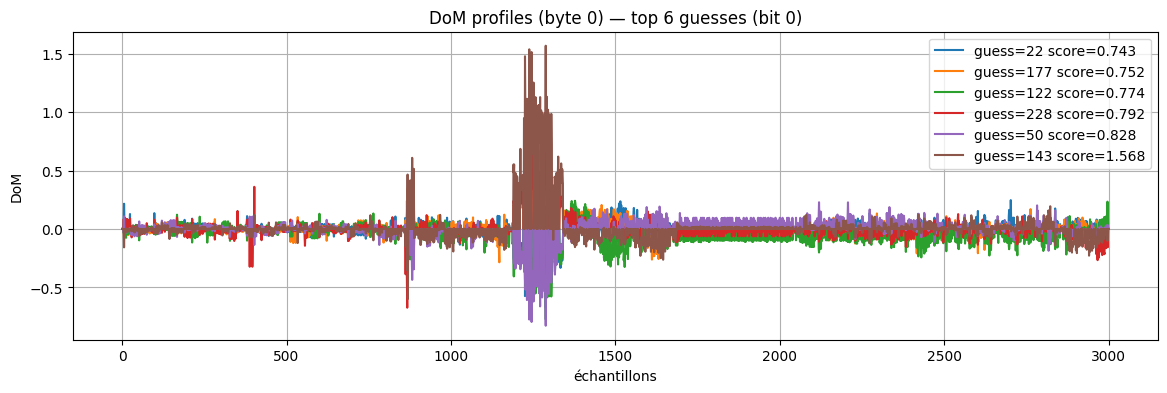

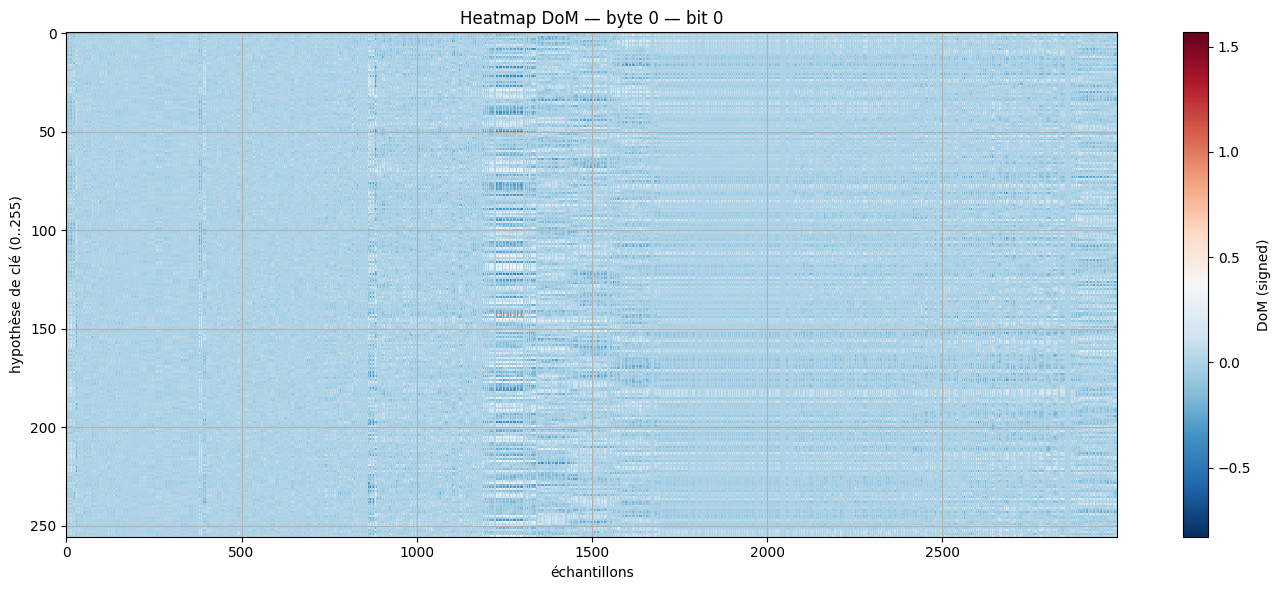

Best guess (par score max) pour byte 0 = 143 (hex 0x8f)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

def compute_DPA_1keybyte(traces, plaintexts, byte_idx, guesses_range=range(256), leakage_bit=0):
    traces = np.asarray(traces)
    plaintexts = np.asarray(plaintexts)
    T = traces.shape[1]
    G = len(list(guesses_range))
    dpa_traces = np.zeros((G, T), dtype=float)
    scores = np.zeros(G, dtype=float)
    for i, g in enumerate(guesses_range):
        # calcul des valeurs SBox pour la guess
        vals = subbyte_vals_for_guess(plaintexts, byte_idx, g)
        sel = ((vals >> leakage_bit) & 1).astype(bool)
        g1 = traces[sel]
        g0 = traces[~sel]
        if g0.shape[0] == 0 or g1.shape[0] == 0:
            diff = np.zeros(T, dtype=float)
        else:
            diff = (g1.mean(axis=0) - g0.mean(axis=0)).astype(float)
        dpa_traces[i] = diff
        scores[i] = float(np.max(np.abs(diff)))
    return dpa_traces, scores

# ---------- paramètres ----------
byte_idx = 0            # octet testé (0..15)
leakage_bit = 0         # bit de fuite testé (0..7)
guesses = range(256)    # toutes les hypothèses
top_k = 6               # combien de guesses afficher

# ---------- calcul DPA (toutes guesses) ---------
dpa_traces, scores = compute_DPA_1keybyte(traces_array, plaintexts, byte_idx,
                                          guesses_range=guesses, leakage_bit=leakage_bit)
print("dpa_traces.shape =", dpa_traces.shape, " scores.shape =", scores.shape)

# ---------- top-k hypotheses ----------
topk_idx = np.argsort(scores)[::-1][:top_k]
print(f"Byte {byte_idx} — top {top_k} guesses (guess, score):")
for g in topk_idx:
    print(f"  {int(g):3d}  score={scores[g]:.6f}")

# ---------- Plot : superposition des DoM des top-k ----------
plt.figure(figsize=(14,4))
for g in topk_idx[::-1]:  # du moins bon au meilleur (pour visibilité)
    plt.plot(dpa_traces[g], label=f"guess={int(g)} score={scores[g]:.3f}")
plt.title(f"DoM profiles (byte {byte_idx}) — top {top_k} guesses (bit {leakage_bit})")
plt.xlabel("échantillons")
plt.ylabel("DoM")
plt.legend(loc='upper right')
plt.show()

# ---------- Heatmap (256 x T) des DoM (valeur signée) ----------
plt.figure(figsize=(14,6))
plt.imshow(dpa_traces, aspect='auto', interpolation='nearest', cmap='RdBu_r')
plt.colorbar(label='DoM (signed)')
plt.xlabel("échantillons")
plt.ylabel("hypothèse de clé (0..255)")
plt.title(f"Heatmap DoM — byte {byte_idx} — bit {leakage_bit}")
plt.tight_layout()
plt.show()


best_guess = int(np.argmax(scores))
print(f"Best guess (par score max) pour byte {byte_idx} = {best_guess} (hex {hex(best_guess)})")

## Attaque DPA complète : 16 octets et récupération de la clé AES

On applique la procédure DoM (Difference of Means) pour chaque octet de clé (0..15).
Pour chaque octet :
- on calcule la DoM pour toutes les hypothèses 0..255 ;
- on mesure un score par hypothèse (max |DoM|) ;
- on choisit l'hypothèse ayant le score maximal comme octet estimé.

On affiche la clé retrouvée et on la compare à la clé réelle.  
On peut aussi afficher les 3 meilleures hypothèses par octet pour inspection.


byte 00 top3 guesses = [143, 50, 228]  scores = [1.5676709784836067, 0.8278534506810562, 0.7919606713707417]
byte 01 top3 guesses = [3, 248, 145]  scores = [1.0182024846311482, 0.6555721013402103, 0.6543501763713415]
byte 02 top3 guesses = [231, 90, 140]  scores = [1.0515567043722172, 0.7041175717213122, 0.696518607442977]
byte 03 top3 guesses = [122, 230, 206]  scores = [1.1101493326285183, 0.8496395890905566, 0.8144313298819692]
byte 04 top3 guesses = [236, 135, 137]  scores = [1.6084408440844093, 0.9905429117381814, 0.8798963133640552]
byte 05 top3 guesses = [102, 248, 13]  scores = [1.0649999999999995, 0.7180451617623329, 0.6893232625498076]
byte 06 top3 guesses = [88, 202, 206]  scores = [1.1269381734543362, 0.734152607373467, 0.6997831574988695]
byte 07 top3 guesses = [10, 56, 183]  scores = [1.0430600935357806, 0.6194693806106386, 0.5936883550270284]
byte 08 top3 guesses = [19, 138, 174]  scores = [1.6446261156528905, 0.8407422667216018, 0.790354097317481]
byte 09 top3 guesses =

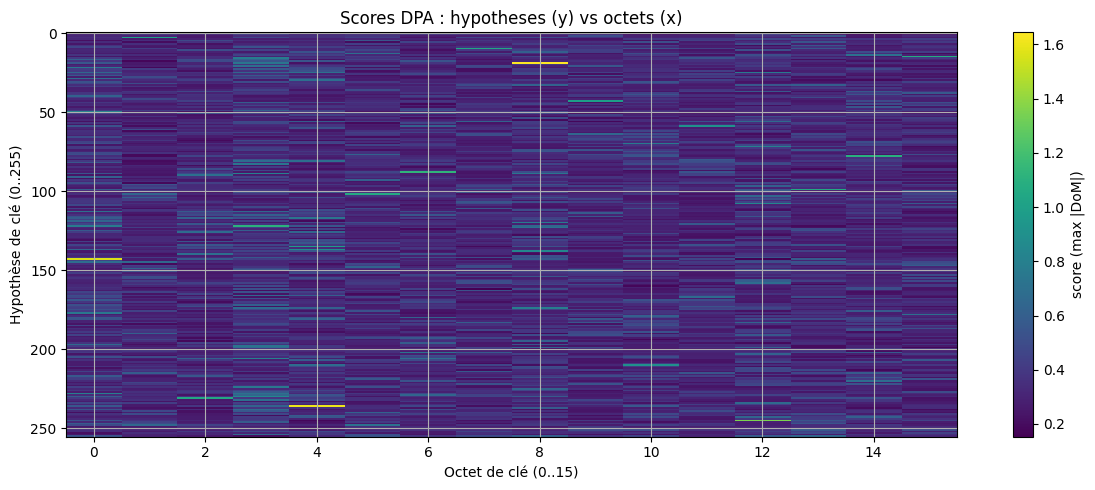

In [36]:

# Paramètres
leakage_bit = 0    # bit testé (0..7) ; 
use_roi = False    # True pour n'utiliser que la ROI ci-dessous
roi = slice(1100, 1700)  # fenêtre 

# Prépare les traces selon ROI
if use_roi:
    traces_used = traces_array[:, roi]
else:
    traces_used = traces_array

# Boucle sur les 16 octets
all_scores = np.zeros((256, 16), dtype=float)
top3_by_byte = {}
for b in range(16):
    dpa_traces_b, scores_b = compute_DPA_1keybyte(traces_used, plaintexts, byte_idx=b,
                                                 guesses_range=range(256), leakage_bit=leakage_bit)
    all_scores[:, b] = scores_b
    top3 = np.argsort(scores_b)[::-1][:3]
    top3_by_byte[b] = top3
    print(f"byte {b:02d} top3 guesses = {[int(x) for x in top3]}  scores = {[float(scores_b[x]) for x in top3]}")

# Reconstruction de la clé par argmax colonne par colonne
found_key = np.argmax(all_scores, axis=0).astype(int)
true_key = np.asarray(ths[0].key).astype(int)

# Affichage résultat
vhex = np.vectorize(lambda x: format(int(x), '#04x'))
print("\nClé retrouvée :", vhex(found_key))
print("Clé correcte  :", vhex(true_key))
print("Octets corrects  :", int(np.sum(found_key == true_key)), "/16")

# Optionnel : heatmap des scores (256 x 16)
plt.figure(figsize=(12,5))
plt.imshow(all_scores, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='score (max |DoM|)')
plt.xlabel("Octet de clé (0..15)")
plt.ylabel("Hypothèse de clé (0..255)")
plt.title("Scores DPA : hypotheses (y) vs octets (x)")
plt.tight_layout()
plt.show()


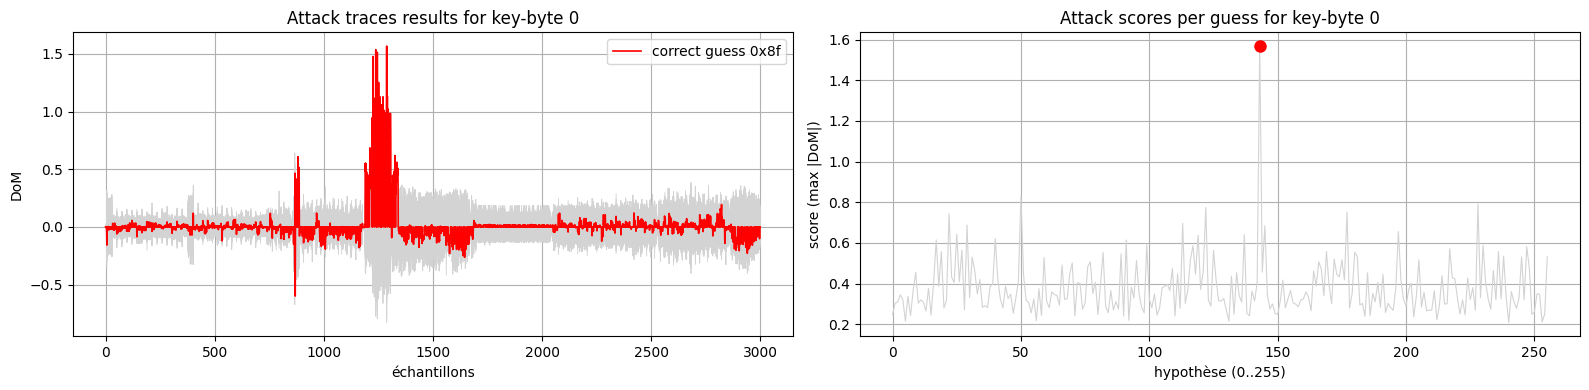

recovered key byte position 0 = 0x8f
Correct key byte position 0 = 0x8f
success



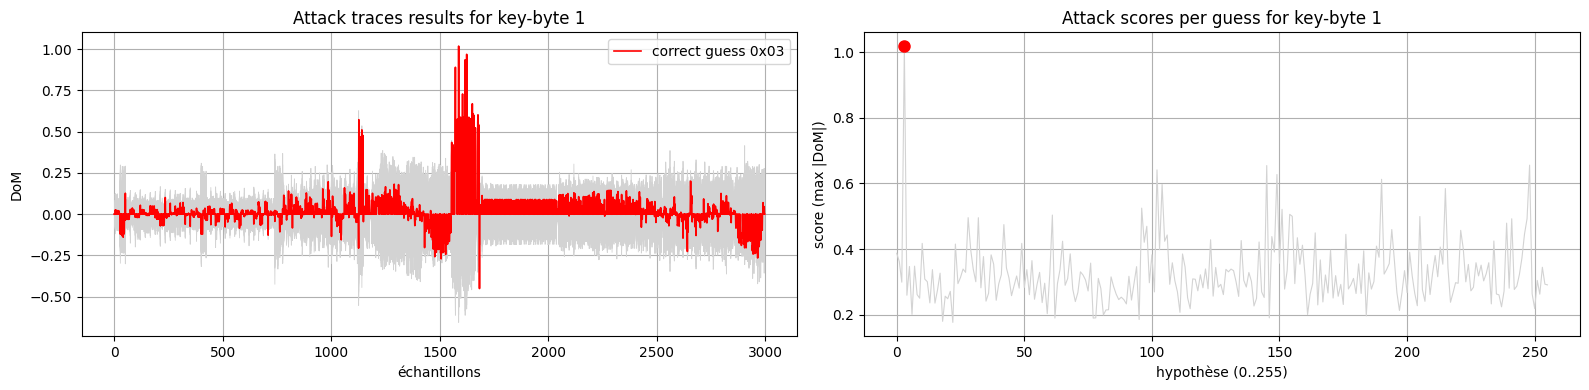

recovered key byte position 1 = 0x3
Correct key byte position 1 = 0x3
success



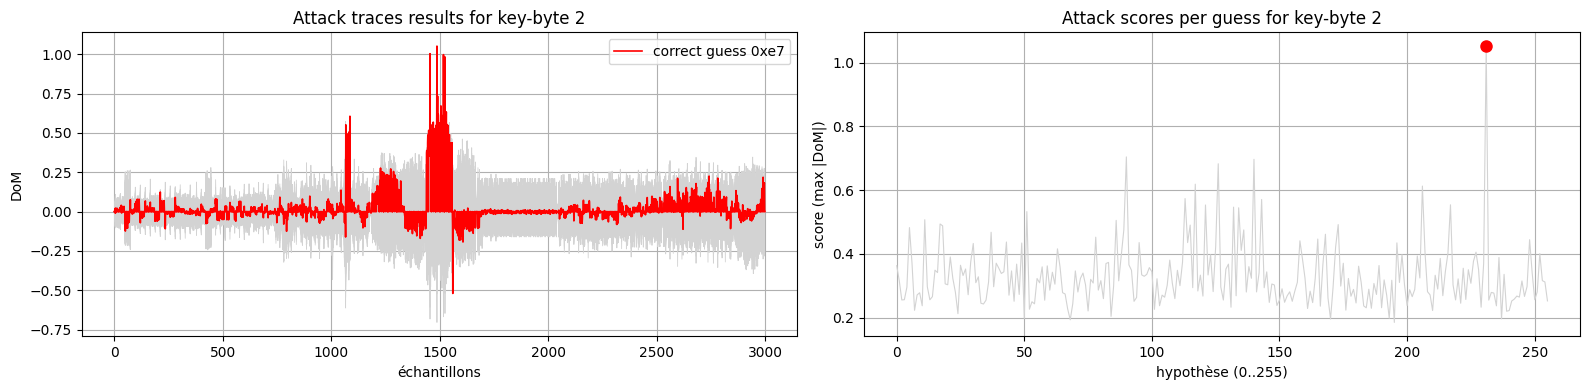

recovered key byte position 2 = 0xe7
Correct key byte position 2 = 0xe7
success



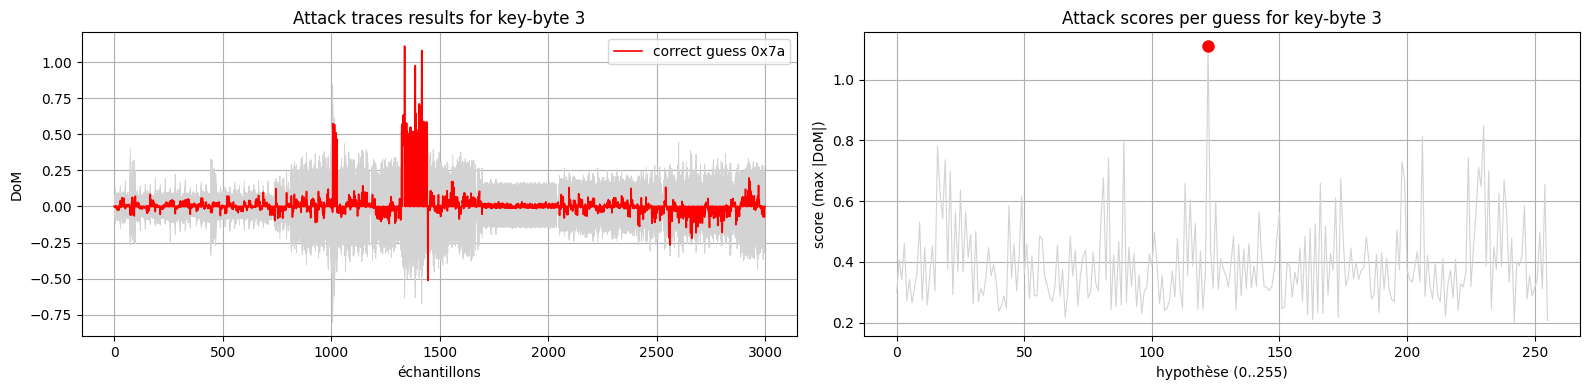

recovered key byte position 3 = 0x7a
Correct key byte position 3 = 0x7a
success



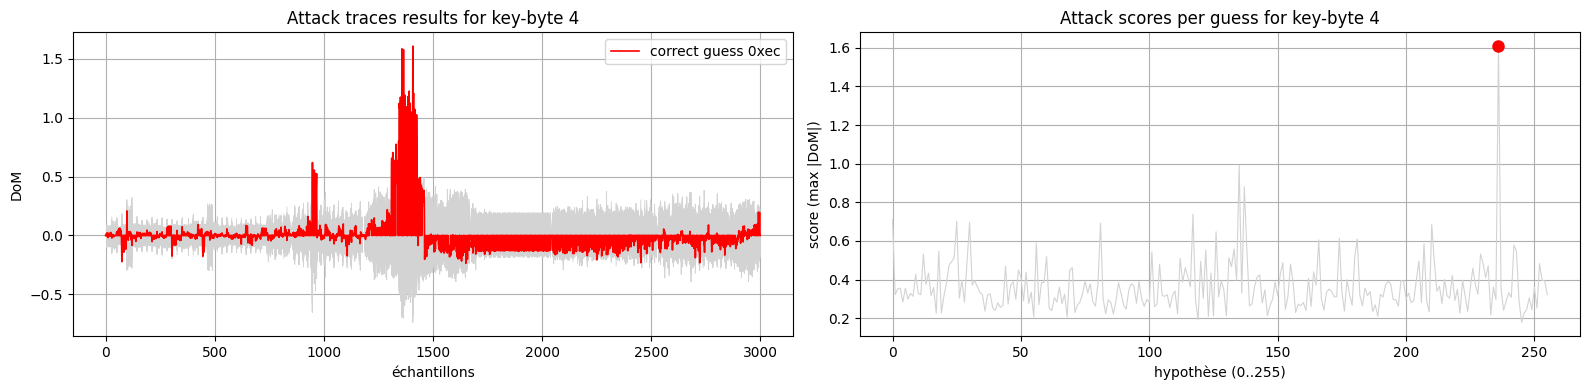

recovered key byte position 4 = 0xec
Correct key byte position 4 = 0xec
success



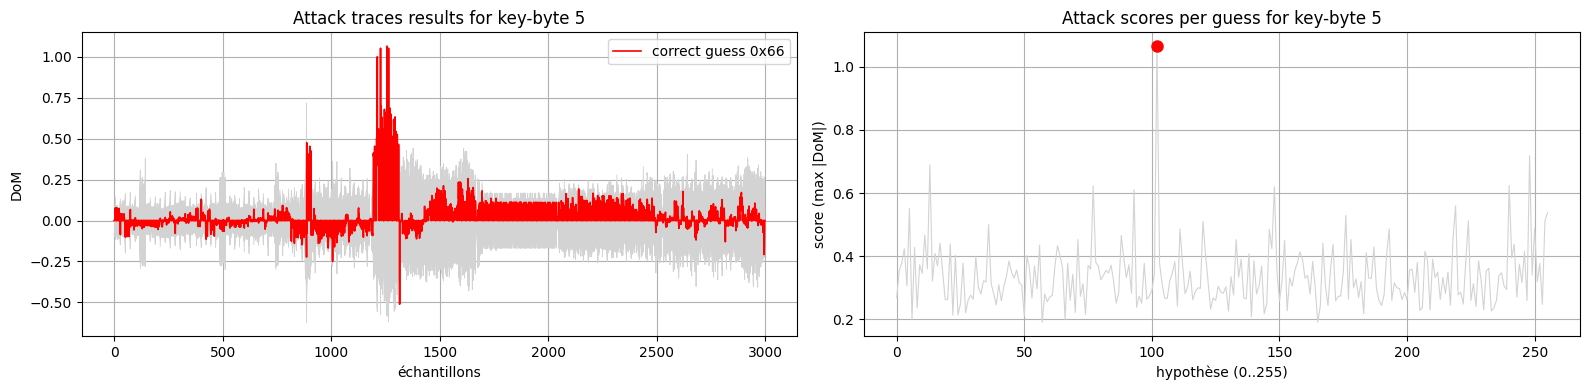

recovered key byte position 5 = 0x66
Correct key byte position 5 = 0x66
success



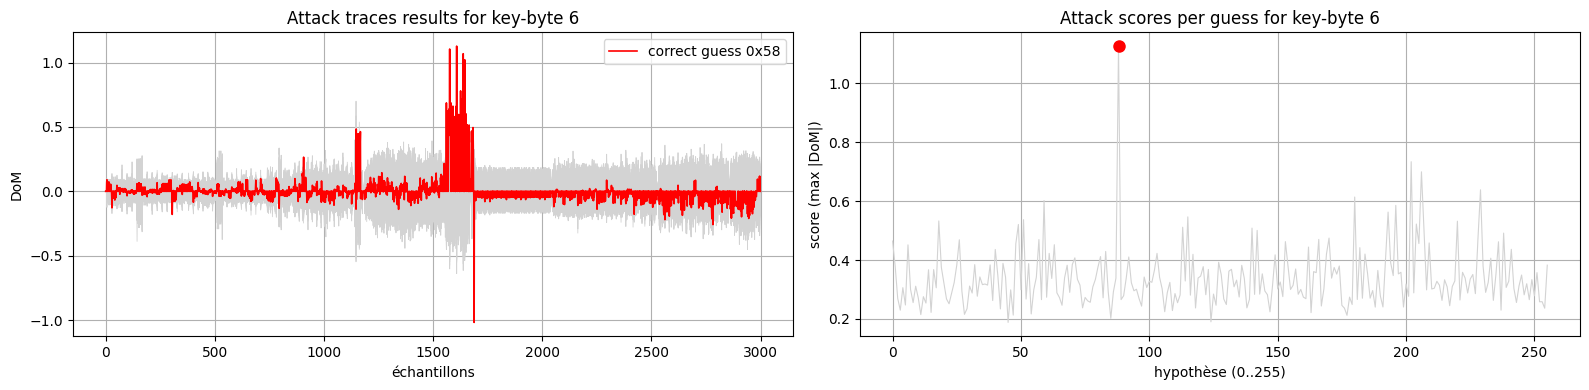

recovered key byte position 6 = 0x58
Correct key byte position 6 = 0x58
success



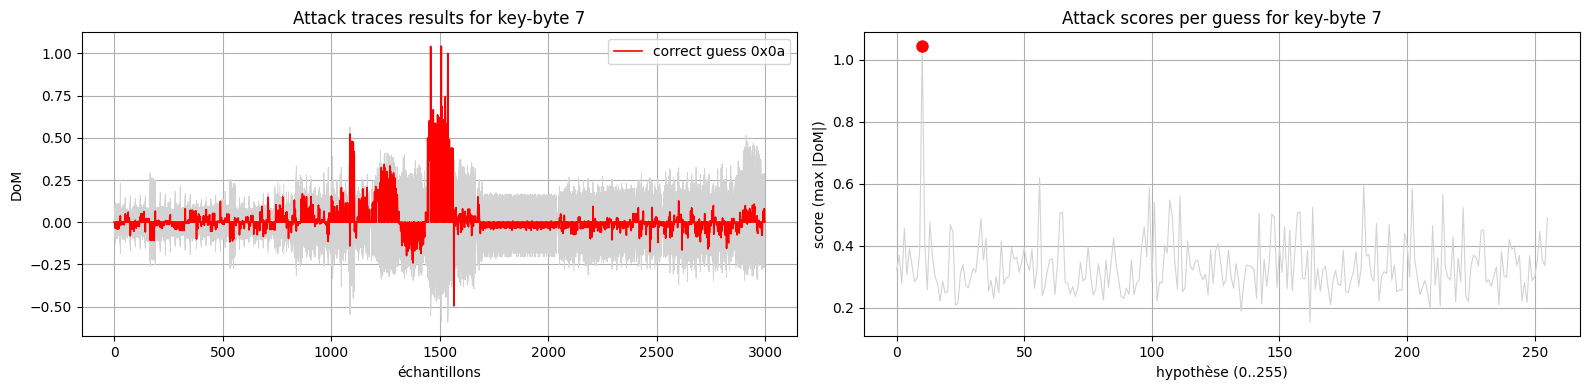

recovered key byte position 7 = 0xa
Correct key byte position 7 = 0xa
success



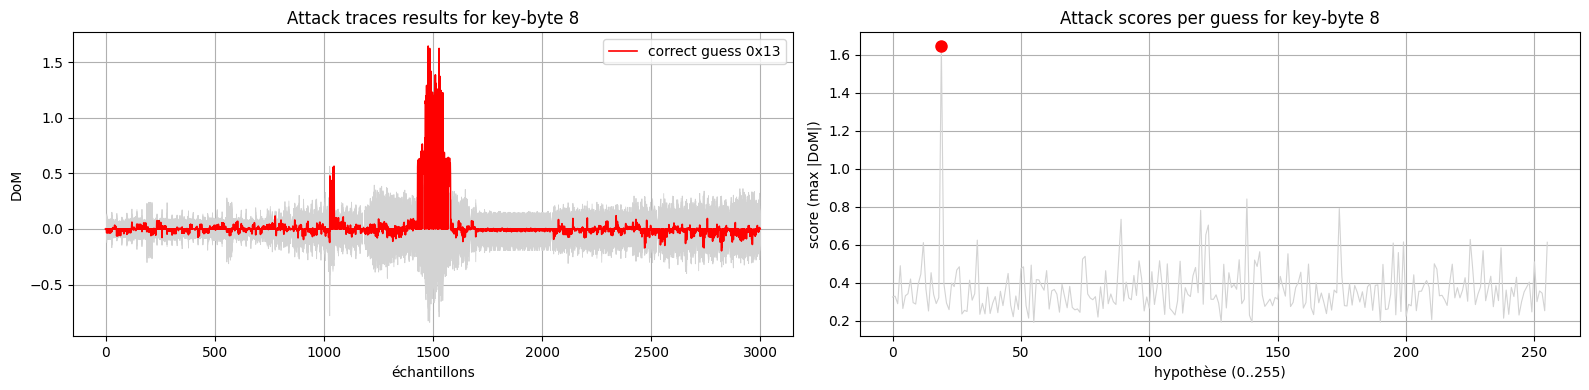

recovered key byte position 8 = 0x13
Correct key byte position 8 = 0x13
success



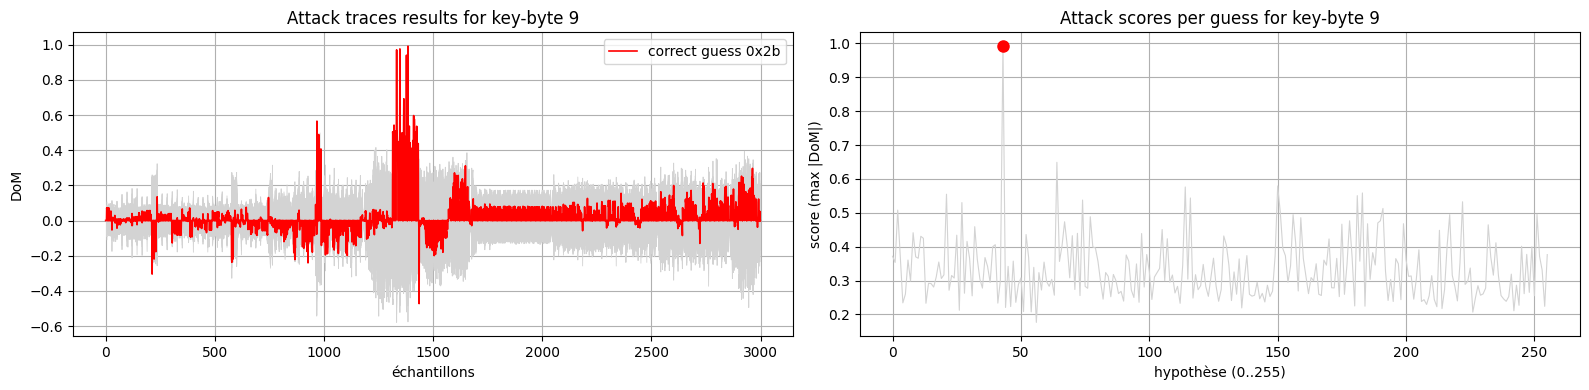

recovered key byte position 9 = 0x2b
Correct key byte position 9 = 0x2b
success



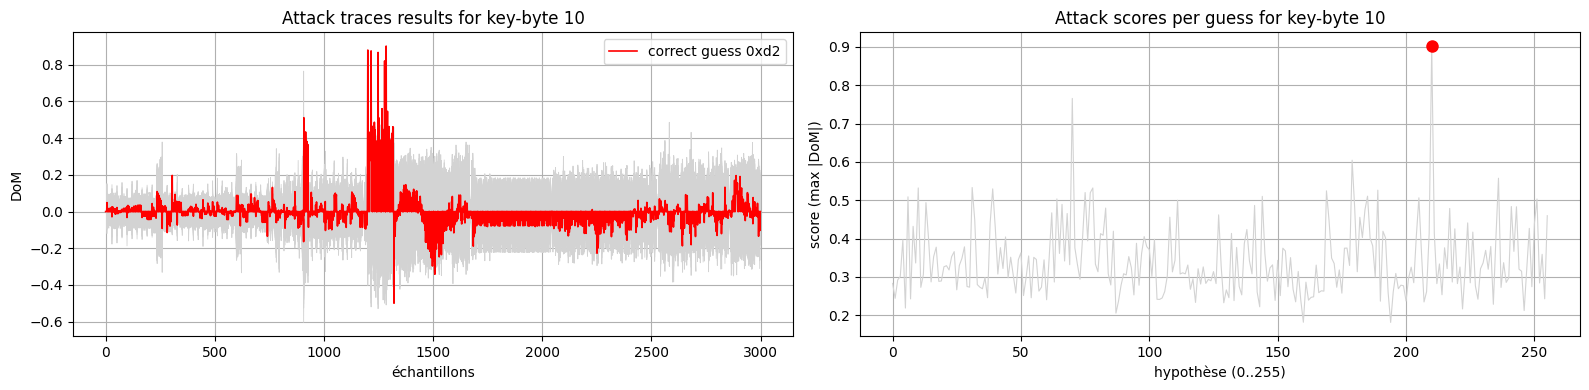

recovered key byte position 10 = 0xd2
Correct key byte position 10 = 0xd2
success



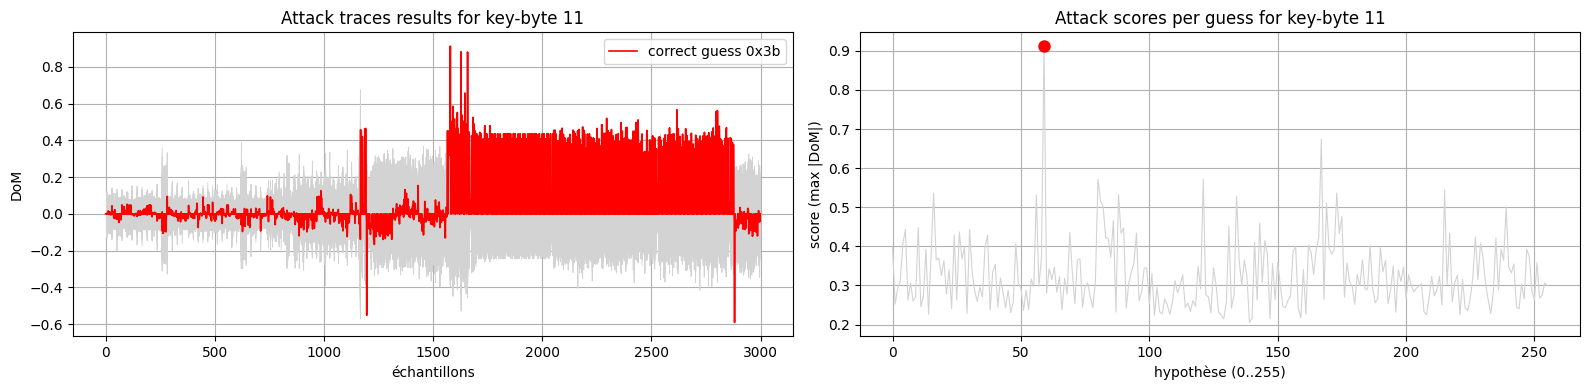

recovered key byte position 11 = 0x3b
Correct key byte position 11 = 0x3b
success



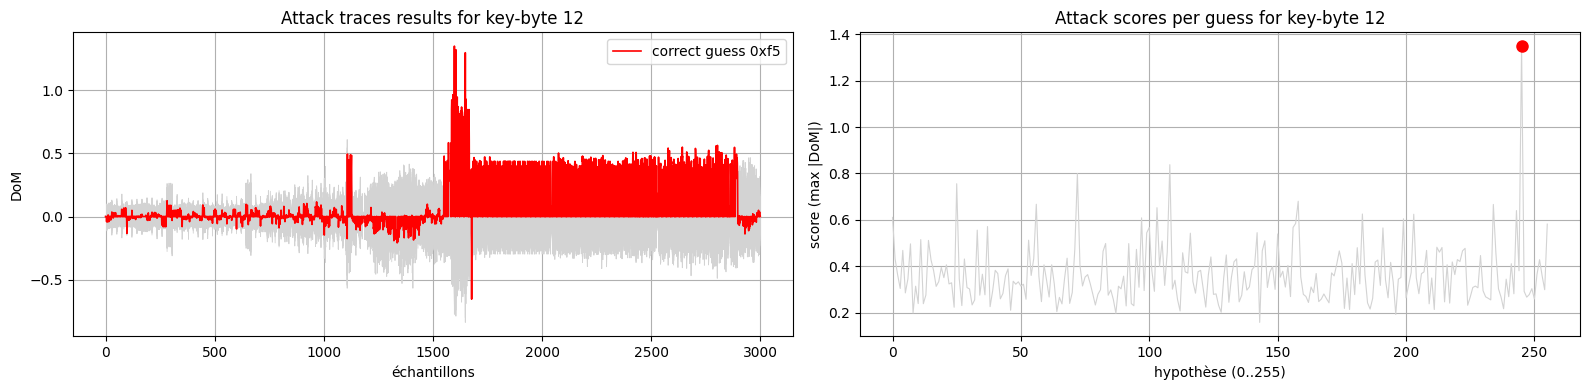

recovered key byte position 12 = 0xf5
Correct key byte position 12 = 0xf5
success



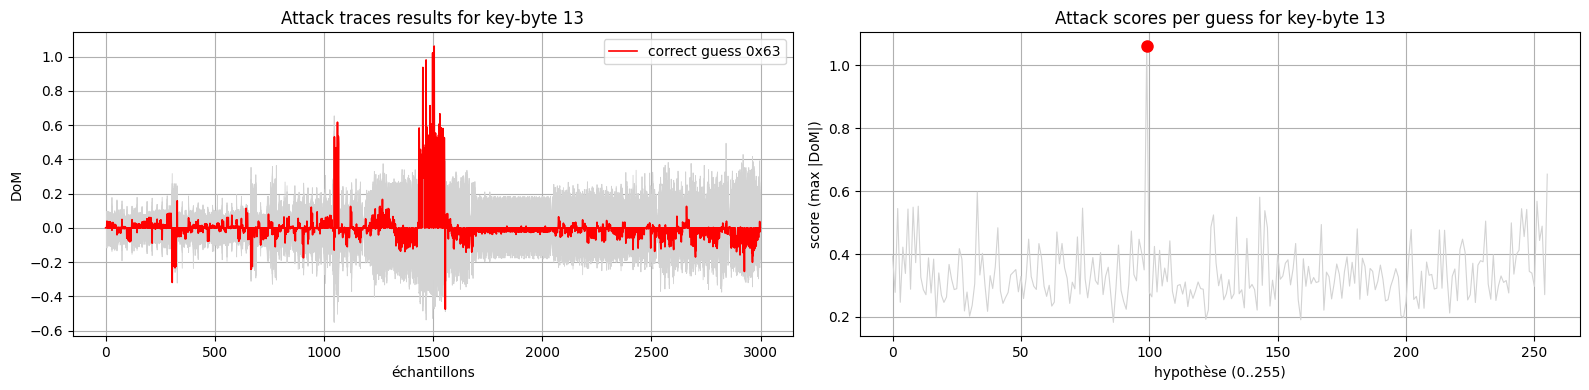

recovered key byte position 13 = 0x63
Correct key byte position 13 = 0x63
success



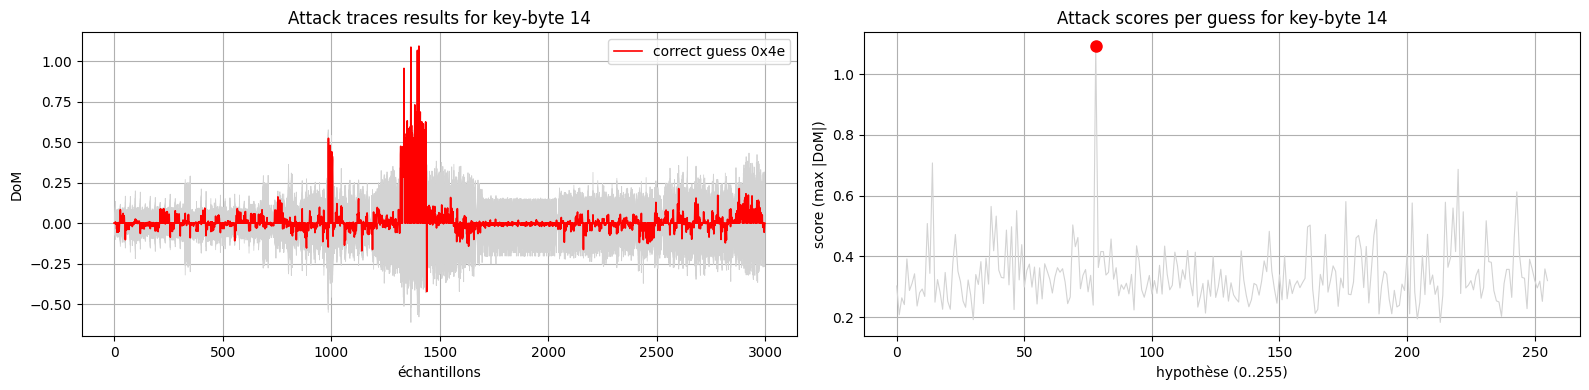

recovered key byte position 14 = 0x4e
Correct key byte position 14 = 0x4e
success



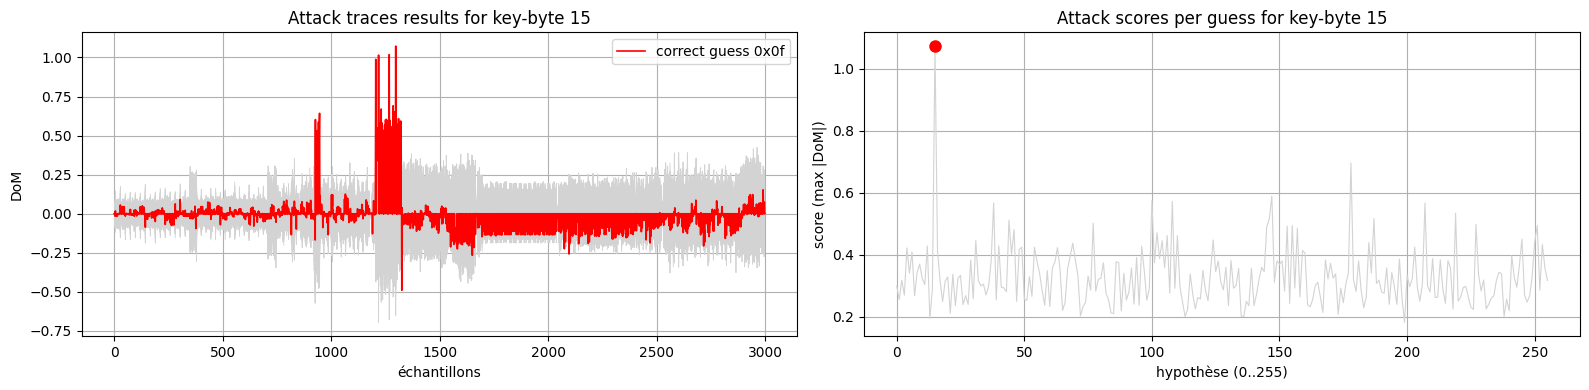

recovered key byte position 15 = 0xf
Correct key byte position 15 = 0xf
success



In [37]:
import matplotlib.pyplot as plt
import numpy as np

# traces_used = traces_array ou traces_roi si ROI utse
use_roi = False
roi = slice(1100,1700)
traces_used = traces_array[:, roi] if use_roi else traces_array

# paramètres
leakage_bit = 0

plt.rcParams['figure.figsize'] = (16, 2)  # taille par paire de subplots (on réinitialisera à l'intérieur)

for key_byte in range(16):
    # calcule DPA pour cet octet (256 x T) et ses scores
    dpa_traces_byte, scores_byte = compute_DPA_1keybyte(traces_used, plaintexts, byte_idx=key_byte,
                                                       guesses_range=range(256), leakage_bit=leakage_bit)

    # bonne hypothèse (vraie clé)
    true_key = np.asarray(ths[0].key).astype(int)
    correct_guess = int(true_key[key_byte])

    # Plot : left = attack traces results (superposé)
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.title(f'Attack traces results for key-byte {key_byte}')
    # toutes les hypotheses en gris
    for guess in range(256):
        plt.plot(dpa_traces_byte[guess], color='lightgrey', linewidth=0.6)
    # la vraie hypothèse en rouge (overlay)
    plt.plot(dpa_traces_byte[correct_guess], color='red', linewidth=1.2, label=f'correct guess {correct_guess:#04x}')
    plt.xlabel("échantillons")
    plt.ylabel("DoM")
    plt.legend(loc='upper right')

    # Plot : right = attack scores per guess
    plt.subplot(1,2,2)
    plt.title(f'Attack scores per guess for key-byte {key_byte}')
    plt.plot(scores_byte, color='lightgrey', linewidth=0.8)
    # marqueur rouge sur la vraie hypothèse
    plt.plot(correct_guess, scores_byte[correct_guess], 'o', color='red', markersize=8)
    plt.xlabel("hypothèse (0..255)")
    plt.ylabel("score (max |DoM|)")

    plt.tight_layout()
    plt.show()

    # affichage texte et test
    found_guess = int(np.argmax(scores_byte))
    print(f"recovered key byte position {key_byte} = {hex(found_guess)}")
    print(f"Correct key byte position {key_byte} = {hex(int(true_key[key_byte]))}")
    if found_guess == int(true_key[key_byte]):
        print("success\n")
    else:
        print("Byte not recovered\n")


In [39]:
leakage_bit = 0
use_roi = False           
roi = (1100, 1700)

true_key  = np.asarray(ths[0].key).astype(int)
found_key = np.asarray(found_key).astype(int) 

vhex = np.vectorize(lambda x: format(int(x), '#04x'))
ok = int(np.sum(found_key == true_key))

print("=== Récapitulatif DPA ===")
print("Modèle de fuite  :", f"Monobit(bit={leakage_bit})")
print("Fenêtre (ROI)    :", f"[{roi[0]}:{roi[1]}]" if use_roi else "trace complète")
print("Clé trouvée      :", vhex(found_key))
print("Clé correcte     :", vhex(true_key))
print(f"Octets corrects  : {ok} / 16")
print("Statut           :", "Succès" if ok == 16 else "Partiel")

=== Récapitulatif DPA ===
Modèle de fuite  : Monobit(bit=0)
Fenêtre (ROI)    : trace complète
Clé trouvée      : ['0x8f' '0x03' '0xe7' '0x7a' '0xec' '0x66' '0x58' '0x0a' '0x13' '0x2b'
 '0xd2' '0x3b' '0xf5' '0x63' '0x4e' '0x0f']
Clé correcte     : ['0x8f' '0x03' '0xe7' '0x7a' '0xec' '0x66' '0x58' '0x0a' '0x13' '0x2b'
 '0xd2' '0x3b' '0xf5' '0x63' '0x4e' '0x0f']
Octets corrects  : 16 / 16
Statut           : Succès
